# <b><span style='color:#9146ff'>|</span> Setting Environment</b> 

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
import os 
import glob as gb 
from tqdm.auto import tqdm

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix , classification_report

import tensorflow as tf
from tensorflow.keras.models import Model 
from tensorflow.keras.callbacks import EarlyStopping

2026-01-28 13:38:17.628374: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1769607497.811691      24 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1769607497.866099      24 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1769607498.313415      24 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1769607498.313466      24 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1769607498.313469      24 computation_placer.cc:177] computation placer alr

In [2]:
sns.set_theme(style='darkgrid', palette='pastel')
color = sns.color_palette(palette='pastel')

# <b><span style='color:#9146ff'>|</span> Reading Dataset</b> 

In [3]:
DATASET_DIR = '/kaggle/input/a-large-scale-fish-dataset/Fish_Dataset/Fish_Dataset'
TEST_DIR = '/kaggle/input/a-large-scale-fish-dataset/NA_Fish_Dataset'

In [4]:
def ReadData(data_dir) : 
    imgs_path , masks_path = [] , []
    labels = []
    label_map = {}
    class_folders = [f for f in sorted(os.listdir(data_dir)) if not (f.endswith('.m') or f.endswith('.txt'))]
    for idx , class_name in tqdm(enumerate(class_folders)) : 
        label_map[idx] = class_name
        for cat in os.listdir(data_dir + "/" + class_name) : 
            if os.path.isdir(data_dir + '/' + class_name + "/" + cat) : 
                if cat.split()[-1] == "GT" : 
                    for folder in os.listdir(data_dir + '/' + class_name + "/" + cat) : 
                        files = gb.glob(pathname = str(data_dir + '/' + class_name + "/" + cat + '/' + folder))
                        for file in files : 
                            masks_path.append(file)
    
                else : 
                    for folder in os.listdir(data_dir + '/' + class_name + "/" + cat) : 
                        files = gb.glob(pathname = str(data_dir + '/' + class_name + "/" + cat + '/' + folder))
                        for file in files : 
                            imgs_path.append(file)
                            labels.append(idx)

            else : 
                files = gb.glob(pathname = str(data_dir + '/' + class_name + "/" + cat))
                for file in files :
                    imgs_path.append(file)
                    labels.append(class_name)


    return np.array(imgs_path) , np.array(masks_path) , np.array(labels) , label_map

In [5]:
ds_imgs , ds_masks , ds_labels , label_map = ReadData(DATASET_DIR)
test_imgs , _ , test_labels , _ = ReadData(TEST_DIR)

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [6]:
len(ds_imgs) , len(test_imgs)

(9000, 430)

In [7]:
label_map

{0: 'Black Sea Sprat',
 1: 'Gilt-Head Bream',
 2: 'Hourse Mackerel',
 3: 'Red Mullet',
 4: 'Red Sea Bream',
 5: 'Sea Bass',
 6: 'Shrimp',
 7: 'Striped Red Mullet',
 8: 'Trout'}

In [8]:
N_CLASSES = len(label_map.keys())
N_CLASSES

9

# <b><span style='color:#9146ff'>|</span> Data Pipeline</b> 

In [9]:
gpus = tf.config.experimental.list_physical_devices('GPU')
AUTOTUNE = tf.data.experimental.AUTOTUNE
for gpu in gpus:
    print("Name:", gpu.name, "  Type:", gpu.device_type)
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

Name: /physical_device:GPU:0   Type: GPU


In [10]:
BATCH_SIZE = 32
IMG_SIZE = 256
BUFFER_SIZE = len(ds_labels)

In [11]:
train_size = round(0.8 * len(ds_labels)) 
val_size = round(0.2 * len(ds_labels))

In [12]:
print(f"The size of the training set is : {train_size}")
print(f"The size of the validation set is : {val_size}")

The size of the training set is : 7200
The size of the validation set is : 1800


In [13]:
train_imgs , val_imgs , train_masks , val_masks , train_labels , val_labels = train_test_split(ds_imgs , ds_masks , ds_labels , train_size = 0.8 , random_state = 42) 

In [14]:
def map_fn(img_path , mask_path , label) : 
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img , channels = 3)
    img = tf.image.resize(img , (IMG_SIZE , IMG_SIZE))
    img = tf.cast(img , tf.float32) / 255.

    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_jpeg(mask , channels = 1)
    mask = tf.image.resize(mask , (IMG_SIZE , IMG_SIZE))
    mask = tf.math.greater(mask , 0)
    mask = tf.cast(mask , tf.float32)

    label = tf.convert_to_tensor(label)
    label = tf.cast(label , tf.float32)

    return img , mask , label

In [15]:
def get_TFds(ds_imgs , ds_masks , ds_labels , shuffle = True) : 
    ds = tf.data.Dataset.from_tensor_slices((ds_imgs , ds_masks , ds_labels))

    if shuffle : 
        ds = ds.shuffle(buffer_size = len(ds_imgs)) 

    ds = ds.map(map_fn) 

    ds = ds.batch(BATCH_SIZE) 

    ds = ds.prefetch(buffer_size = AUTOTUNE)

    return ds

In [16]:
train_ds = get_TFds(train_imgs , train_masks , train_labels)
val_ds = get_TFds(val_imgs , val_masks , val_labels , shuffle = False)

I0000 00:00:1769607544.181114      24 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


In [17]:
print(f"the size of the train ds : {len(train_ds)} batches of {BATCH_SIZE}\n")
print(f"the size of the validation ds : {len(val_ds)} batches of {BATCH_SIZE}\n")

the size of the train ds : 225 batches of 32

the size of the validation ds : 57 batches of 32



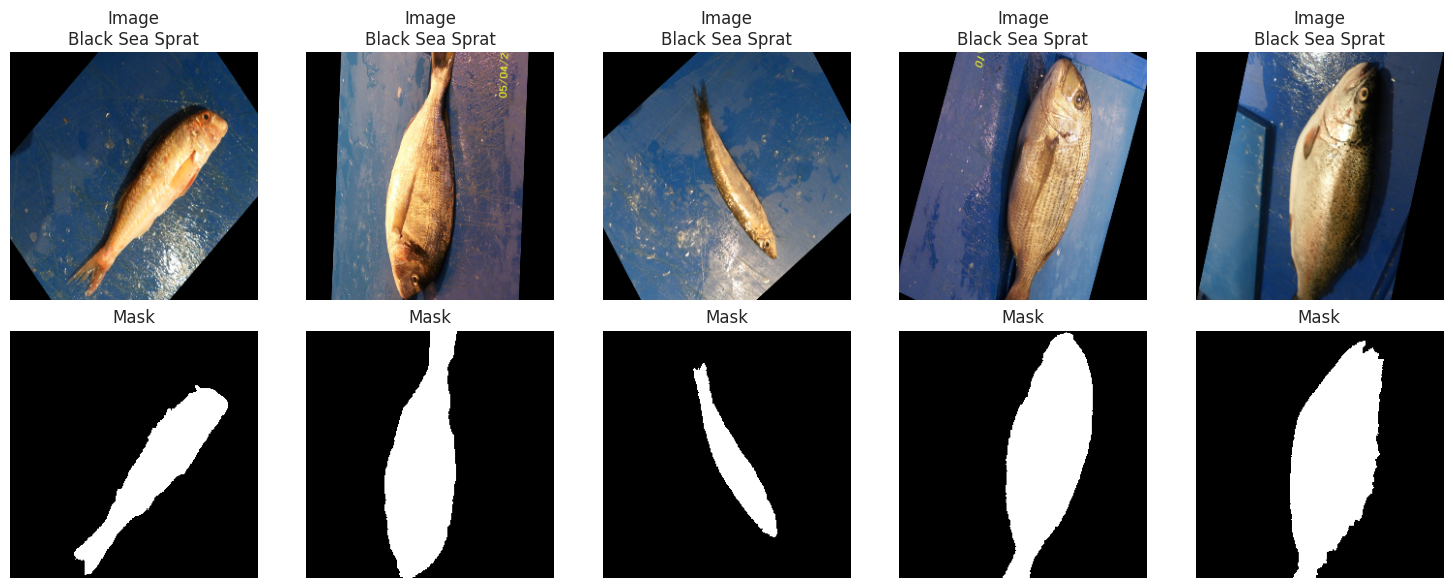

In [18]:
def plot_batch(img_batch, mask_batch, label_batch):
    plt.figure(figsize=(15, 6))

    for i in range(5): 
        img = img_batch[i].numpy()
        mask = mask_batch[i].numpy().squeeze()
        label = np.argmax(label_batch[i].numpy())

        plt.subplot(2, 5, i + 1)
        plt.imshow(img)
        plt.title(f"Image\n{label_map[label]}")
        plt.axis("off")
        
        plt.subplot(2, 5, i + 6)
        plt.imshow(mask, cmap='gray')
        plt.title("Mask")
        plt.axis("off")

    plt.tight_layout()
    plt.show()


img_sample , mask_sample , label_sample = next(iter(val_ds)) 
plot_batch(img_sample, mask_sample, label_sample)

# <b><span style='color:#9146ff'>|</span> Training & Evaluation</b> 

In [19]:
import tensorflow as tf
from tensorflow.keras import layers, Model

class MyModel(Model):
    def __init__(self):
        super().__init__()
        # Standard Python list is sufficient!
        # Keras will track these variables automatically.
        self.hidden_layers = [
            layers.Dense(10) for _ in range(5)
        ]

    def call(self, x):
        for layer in self.hidden_layers:
            x = layer(x)
        return x

In [20]:
class UNET(Model) : 
    def __init__(self , n_classes) : 
        super(UNET , self).__init__()

        # Encoder
        self.enc_layer = tf.keras.Sequential([
            tf.keras.layers.Conv2D(32 , 3 , strides = 1 , padding = 'same') , 
            tf.keras.layers.BatchNormalization() , 
            tf.keras.layers.ReLU()
        ])

        self.encoders = [
            self.ConvBlock(filters) for filters in [64 , 128 , 256 , 512]
        ]

        self.pool = tf.keras.layers.MaxPooling2D(2, strides = 2 , padding = 'same')

        self.bottleneck = self.ConvBlock(1024)

        # Decoder
        self.decoders = [
            self.ConvBlock(filters) for filters in [512 , 256 , 128 , 64]
        ]

        self.up_samples = [
            tf.keras.layers.Conv2DTranspose(filters , 2 , strides = 2 , padding = 'same') 
            for filters in [512 , 256 , 128 , 64]
        ]

        
        self.mask_output = tf.keras.layers.Conv2D(1 , 1 , strides = 1 , activation = 'sigmoid' , name = 'mask')
        self.cls = tf.keras.Sequential([
            tf.keras.layers.GlobalAveragePooling2D() , 
            tf.keras.layers.Dense(256 , activation = 'relu') , 
            tf.keras.layers.Dense(n_classes , activation = 'softmax' , name = 'class')
        ])

        self.concat = tf.keras.layers.Concatenate(axis = -1)

    def ConvBlock(self , filters) : 
        return tf.keras.Sequential([
            tf.keras.layers.Conv2D(filters , 3 , strides = 1 , padding = 'same') , 
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.ReLU() , 

            tf.keras.layers.Conv2D(filters , 3 , strides = 1 , padding = 'same'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.ReLU()
        ])

    def call(self , x) : 
        resduials = []

        # Encoder 
        x = self.enc_layer(x)

        for enc in self.encoders : 
            x = enc(x)
            resduials.append(x)
            x = self.pool(x)

        bottleneck = self.bottleneck(x)
        x = bottleneck

        # Decoder
        for idx , dec in enumerate(self.decoders) : 
            x = self.up_samples[idx](x)
            residual = resduials.pop()
            x = self.concat([x, residual])
            x = dec(x)

        mask_out = self.mask_output(x)
        class_out = self.cls(bottleneck)

        return {"mask": mask_out, "class": class_out}

    def summary(self) : 
        x = tf.keras.layers.Input(shape = (IMG_SIZE , IMG_SIZE , 3))
        model = Model(inputs = [x] , outputs = self.call(x))
        return model.summary()

    def plot(self) : 
        x = tf.keras.layers.Input(shape = (IMG_SIZE , IMG_SIZE , 3))
        model = Model(inputs = [x] , outputs = self.call(x))
        return tf.keras.utils.plot_model(model, show_shapes=True)

In [21]:
tf.keras.backend.clear_session()
model = UNET(N_CLASSES)

In [22]:
model.summary()

Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential          │ (None, 256, 256,  │      1,024 │ input_layer[0][0] │
│ (Sequential)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_1        │ (None, 256, 256,  │     55,936 │ sequential[0][0]  │
│ (Sequential)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 16, 16,    │          0 │ sequential_1[0][… │
│ (MaxPooling2D)      │ 512)              │            │ sequential_2[0][… │
│                     │                   │            │ sequential_3[0][… │
│                     │                   │            │ sequential_4[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_2        │ (None, 128, 128,  │    222,464 │ max_pooling2d[0]… │
│ (Sequential)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_3        │ (None, 64, 64,    │    887,296 │ max_pooling2d[1]… │
│ (Sequential)        │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_4        │ (None, 32, 32,    │  3,544,064 │ max_pooling2d[2]… │
│ (Sequential)        │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_5        │ (None, 16, 16,    │ 14,166,016 │ max_pooling2d[3]… │
│ (Sequential)        │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose    │ (None, 32, 32,    │  2,097,664 │ sequential_5[0][… │
│ (Conv2DTranspose)   │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 256, 256,  │          0 │ conv2d_transpose… │
│ (Concatenate)       │ 128)              │            │ sequential_4[0][… │
│                     │                   │            │ conv2d_transpose… │
│                     │                   │            │ sequential_3[0][… │
│                     │                   │            │ conv2d_transpose… │
│                     │                   │            │ sequential_2[0][… │
│                     │                   │            │ conv2d_transpose… │
│                     │                   │            │ sequential_1[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_6        │ (None, 32, 32,    │  7,083,008 │ concatenate[0][0] │
│ (Sequential)        │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_1  │ (None, 64, 64,    │    524,544 │ sequential_6[0][… │
│ (Conv2DTranspose)   │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_7        │ (None, 64, 64,    │  1,772,032 │ concatenate[1][0] │
│ (Sequential)        │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_2  │ (None, 128, 128,  │    131,200 │ sequential_7[0][… │
│ (Conv2DTranspose)   │ 128)              │            │                 

 Total params: 31,337,738 (119.54 MB)

 Trainable params: 31,325,898 (119.50 MB)

 Non-trainable params: 11,840 (46.25 KB)

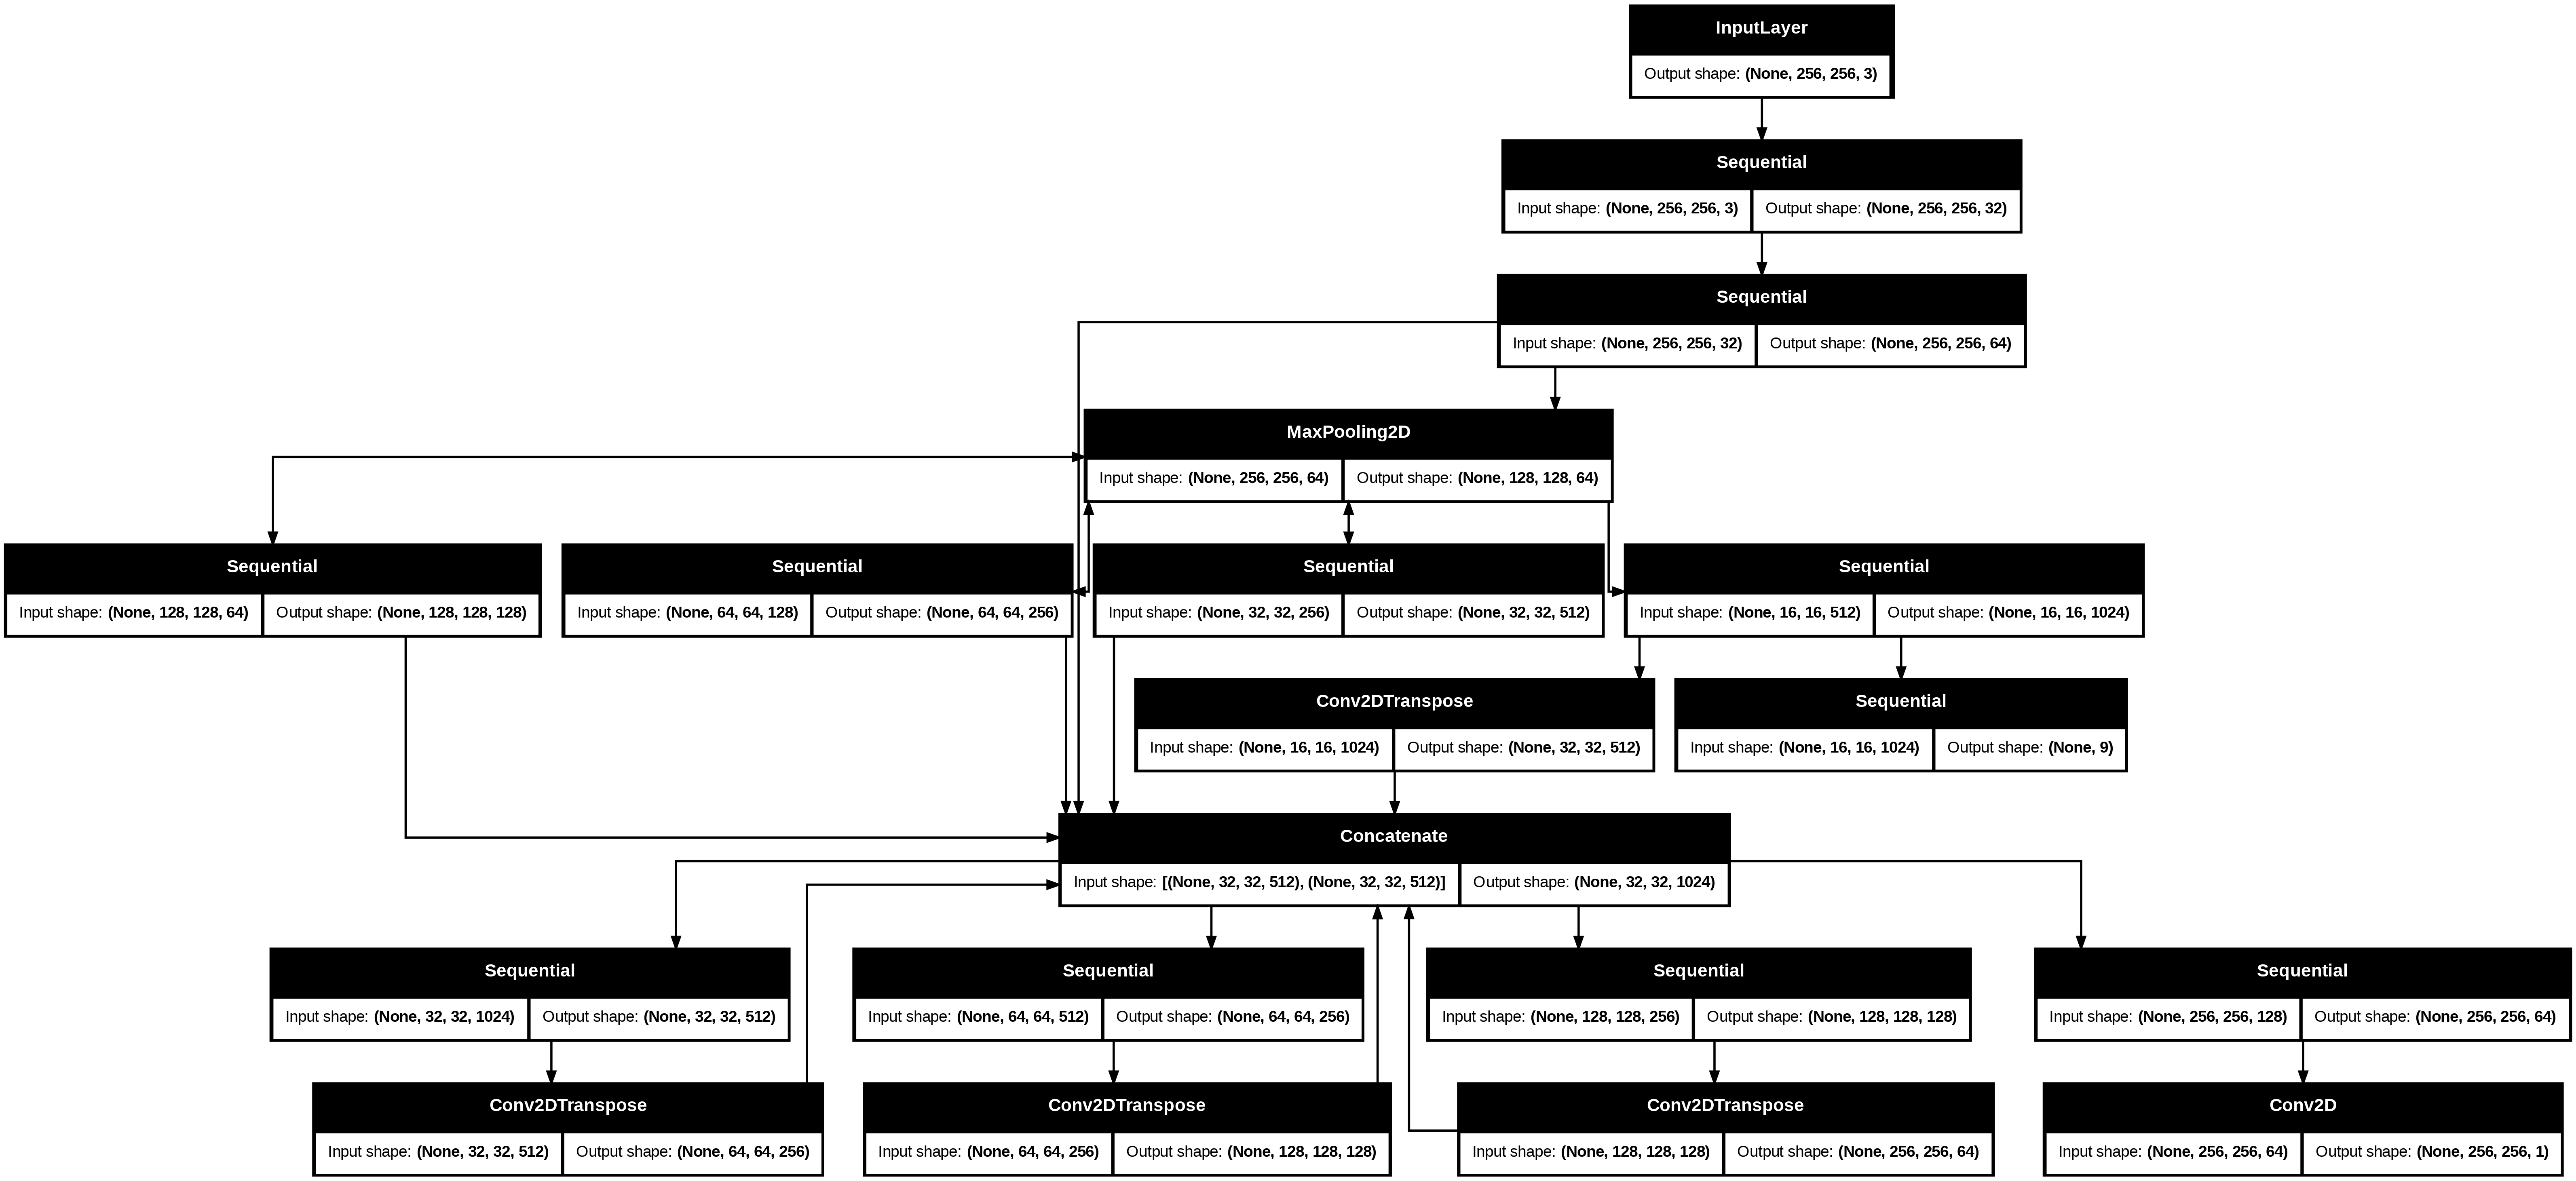

In [23]:
model.plot()

In [24]:
EPOCHS = 10
CLASS_LOSS = tf.keras.losses.SparseCategoricalCrossentropy()
MASK_LOSS = tf.keras.losses.BinaryCrossentropy() 
OPTIM = tf.keras.optimizers.Adam(learning_rate=0.0001)
METRICS = ['accuracy']
CALLBACKS = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=1)

In [25]:
model.compile(
    optimizer = OPTIM , 
    loss = {
        "mask" : MASK_LOSS , 
        "class" : CLASS_LOSS
    } , 
    loss_weights = {
        "mask" : 1.0 , 
        "class" : 1.0
    } , 
    metrics = {
        "mask" : METRICS , 
        "class" : METRICS
    }
)

In [26]:
def ds_to_model(ds) : 
    return ds.map(
        lambda x , y_mask , y_class : (
            x , 
            {
                "mask" : y_mask , 
                "class" : y_class
            }
        )
    )

train_ds = ds_to_model(train_ds)
val_ds = ds_to_model(val_ds)

In [27]:
with tf.device("/GPU:0") :
    history = model.fit(
        train_ds , 
        validation_data = val_ds , 
        epochs = EPOCHS , 
        callbacks = [CALLBACKS]
    )

Epoch 1/10


I0000 00:00:1769607559.038229      64 service.cc:152] XLA service 0x7a656004a540 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1769607559.038269      64 service.cc:160]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1769607561.487770      64 cuda_dnn.cc:529] Loaded cuDNN version 91002
2026-01-28 13:39:28.759682: E external/local_xla/xla/service/slow_operation_alarm.cc:73] Trying algorithm eng12{k11=2} for conv %cudnn-conv-bias-activation.67 = (f32[32,128,128,128]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,128,128,128]{3,2,1,0} %bitcast.17414, f32[128,128,3,3]{3,2,1,0} %bitcast.14573, f32[128]{0} %bitcast.17474), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="unet_1/sequential_2_1/conv2d_4_1/convolution" source_file="/usr/local/lib/python3.12/dist-packages/tensorflow/python/framework/ops.py" sourc

225/225 ━━━━━━━━━━━━━━━━━━━━ 266s 828ms/step - class_accuracy: 0.1636 - class_loss: 2.0869 - loss: 2.4036 - mask_accuracy: 0.9070 - mask_loss: 0.3167 - val_class_accuracy: 0.4083 - val_class_loss: 1.5440 - val_loss: 1.6317 - val_mask_accuracy: 0.9678 - val_mask_loss: 0.0869
Epoch 2/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 177s 785ms/step - class_accuracy: 0.4008 - class_loss: 1.5251 - loss: 1.6097 - mask_accuracy: 0.9689 - mask_loss: 0.0846 - val_class_accuracy: 0.4506 - val_class_loss: 1.3733 - val_loss: 1.4702 - val_mask_accuracy: 0.9693 - val_mask_loss: 0.0925
Epoch 3/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 177s 785ms/step - class_accuracy: 0.4753 - class_loss: 1.3192 - loss: 1.3955 - mask_accuracy: 0.9726 - mask_loss: 0.0763 - val_class_accuracy: 0.5861 - val_class_loss: 1.0968 - val_loss: 1.1652 - val_mask_accuracy: 0.9754 - val_mask_loss: 0.0666
Epoch 4/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 177s 787ms/step - class_accuracy: 0.6070 - class_loss: 1.0237 - loss: 1.0904 - mask_accuracy: 0.9757 - mask_loss:

In [28]:
print(f"The training loss is : {history.history['loss'][-1]:0.2f}\n")
print(f"The training class loss is : {history.history['class_loss'][-1]:0.2f}\n")
print(f"The training mask loss is : {history.history['mask_loss'][-1]:0.2f}\n")
print(f"The training class accuracy is : {(history.history['class_accuracy'][-1]*100):0.2f}%\n")
print(f"The training mask accuracy is : {(history.history['mask_accuracy'][-1]*100):0.2f}%\n")

The training loss is : 0.16

The training class loss is : 0.11

The training mask loss is : 0.04

The training class accuracy is : 96.03%

The training mask accuracy is : 98.41%



In [29]:
print(f"The validation loss is : {history.history['val_loss'][-1]:0.2f}\n")
print(f"The validation class loss is : {history.history['val_class_loss'][-1]:0.2f}\n")
print(f"The validation mask loss is : {history.history['val_mask_loss'][-1]:0.2f}\n")
print(f"The validation class accuracy is : {(history.history['val_class_accuracy'][-1]*100):0.2f}%\n")
print(f"The validation mask accuracy is : {(history.history['val_mask_accuracy'][-1]*100):0.2f}%\n")

The validation loss is : 0.10

The validation class loss is : 0.06

The validation mask loss is : 0.04

The validation class accuracy is : 98.06%

The validation mask accuracy is : 98.35%



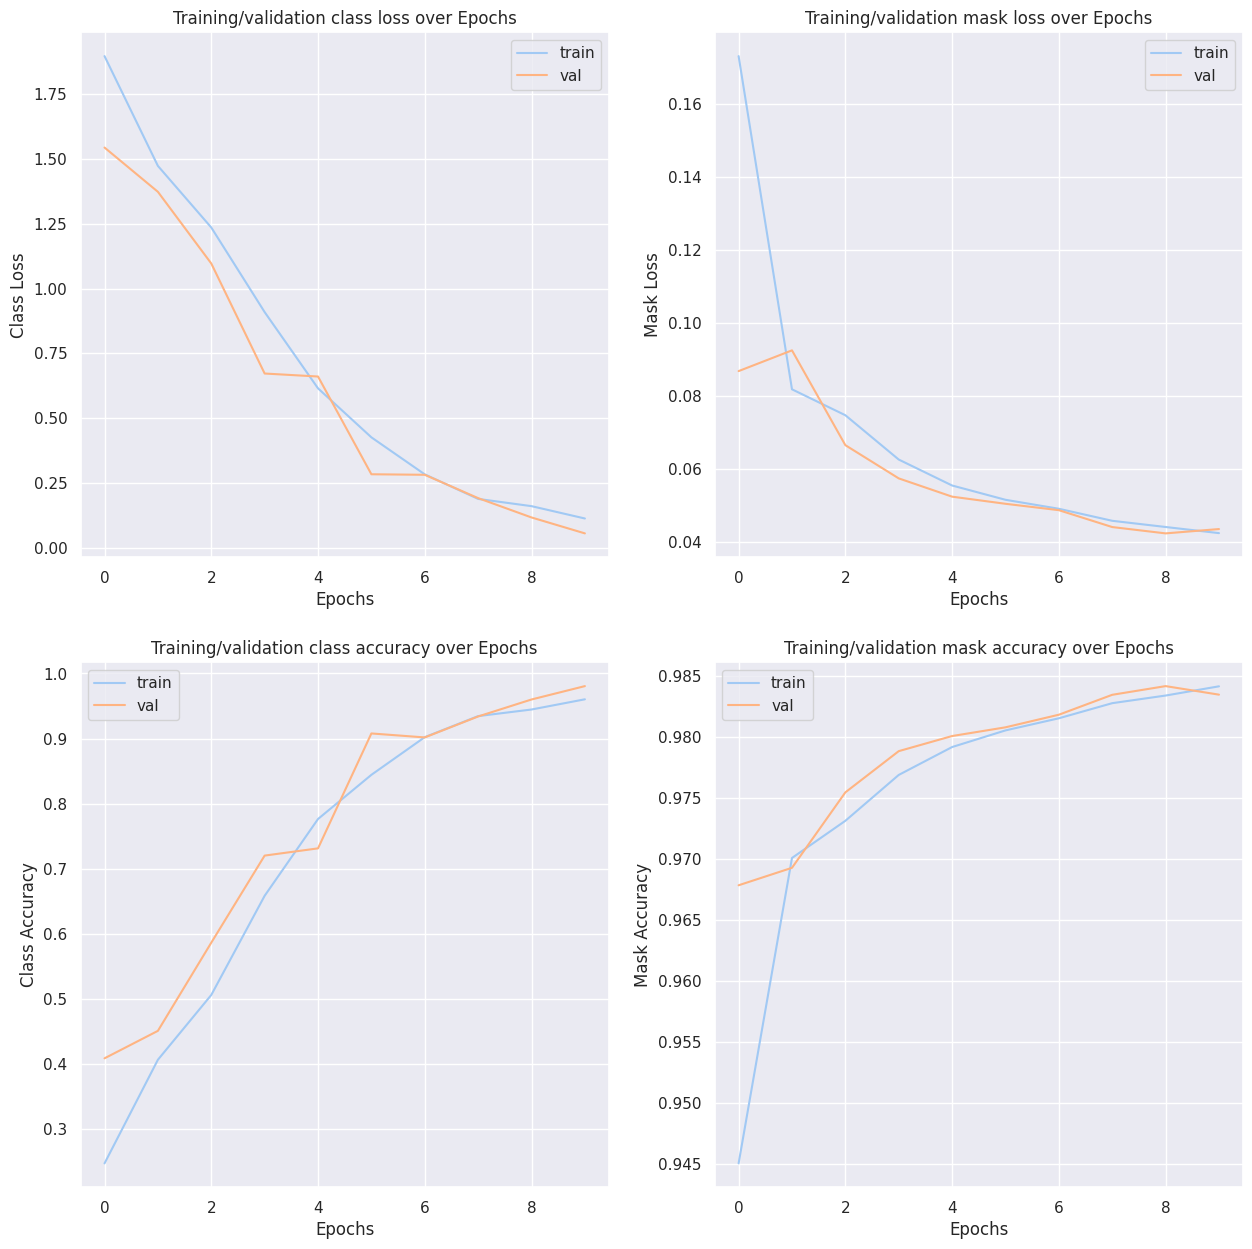

In [30]:
figure , axis = plt.subplots(2,2,figsize=(15,15))


axis[0,0].plot(history.history['class_loss'] , label='train')
axis[0,0].plot(history.history['val_class_loss'] , label='val')
axis[0,0].set_title('Training/validation class loss over Epochs')
axis[0,0].set_xlabel('Epochs')
axis[0,0].set_ylabel('Class Loss')
axis[0,0].legend()


axis[1,0].plot(history.history['class_accuracy'], label='train')
axis[1,0].plot(history.history['val_class_accuracy'], label='val')
axis[1,0].set_title('Training/validation class accuracy over Epochs')
axis[1,0].set_xlabel('Epochs')
axis[1,0].set_ylabel('Class Accuracy')
axis[1,0].legend()


axis[0,1].plot(history.history['mask_loss'], label='train')
axis[0,1].plot(history.history['val_mask_loss'], label='val')
axis[0,1].set_title('Training/validation mask loss over Epochs')
axis[0,1].set_xlabel('Epochs')
axis[0,1].set_ylabel('Mask Loss')
axis[0,1].legend()


axis[1,1].plot(history.history['mask_accuracy'], label='train')
axis[1,1].plot(history.history['val_mask_accuracy'], label='val')
axis[1,1].set_title('Training/validation mask accuracy over Epochs')
axis[1,1].set_xlabel('Epochs')
axis[1,1].set_ylabel('Mask Accuracy')
axis[1,1].legend()

In [31]:
with tf.device("/GPU:0") :
    y_preds = model.predict(val_ds)

57/57 ━━━━━━━━━━━━━━━━━━━━ 18s 283ms/step


In [32]:
print(y_preds.keys())


dict_keys(['mask', 'class'])


In [33]:
y_true = np.concatenate([y['class'] for _, y in val_ds], axis=0)
y_preds = np.argmax(y_preds['class'].round() , axis = 1)

				--- Validation Metrics ---

                    precision    recall  f1-score   support

   Black Sea Sprat       0.96      0.97      0.97       195
   Gilt-Head Bream       0.99      0.98      0.99       211
   Hourse Mackerel       0.97      0.99      0.98       179
        Red Mullet       1.00      0.99      0.99       191
     Red Sea Bream       0.99      0.97      0.98       203
          Sea Bass       0.94      0.99      0.96       207
            Shrimp       1.00      0.98      0.99       209
Striped Red Mullet       0.99      0.95      0.97       204
             Trout       0.99      1.00      0.99       201

          accuracy                           0.98      1800
         macro avg       0.98      0.98      0.98      1800
      weighted avg       0.98      0.98      0.98      1800




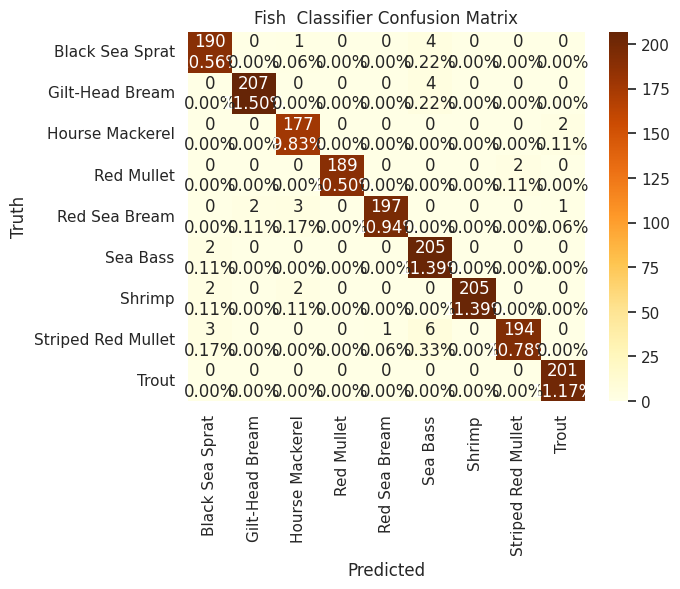

In [34]:
print("\t\t\t\t--- Validation Metrics ---\n")
print(f"{classification_report(y_true, y_preds , target_names = label_map.values())}\n")

cm = confusion_matrix(y_true,y_preds)
cm_percent = cm / cm.sum() * 100

cm_labels = np.array([
    [f"{cm[i, j]}\n{cm_percent[i, j]:.2f}%" for j in range(cm.shape[1])]
    for i in range(cm.shape[0])
])

sns.heatmap(
    cm,
    annot = cm_labels,
    fmt ='',
    cmap = 'YlOrBr',
    xticklabels=list(label_map.values()), 
    yticklabels=list(label_map.values())
) 
plt.title('Fish  Classifier Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

# <b><span style='color:#9146ff'>|</span> Make Predictions</b> 

In [35]:
def read_image(path) : 
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img , channels = 3)
    img = tf.image.resize(img , (IMG_SIZE , IMG_SIZE))
    img = tf.cast(img , tf.float32) / 255.

    return img

2026-01-28 14:10:37.792771: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-01-28 14:10:38.027251: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-01-28 14:10:38.585029: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-01-28 14:10:38.841924: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


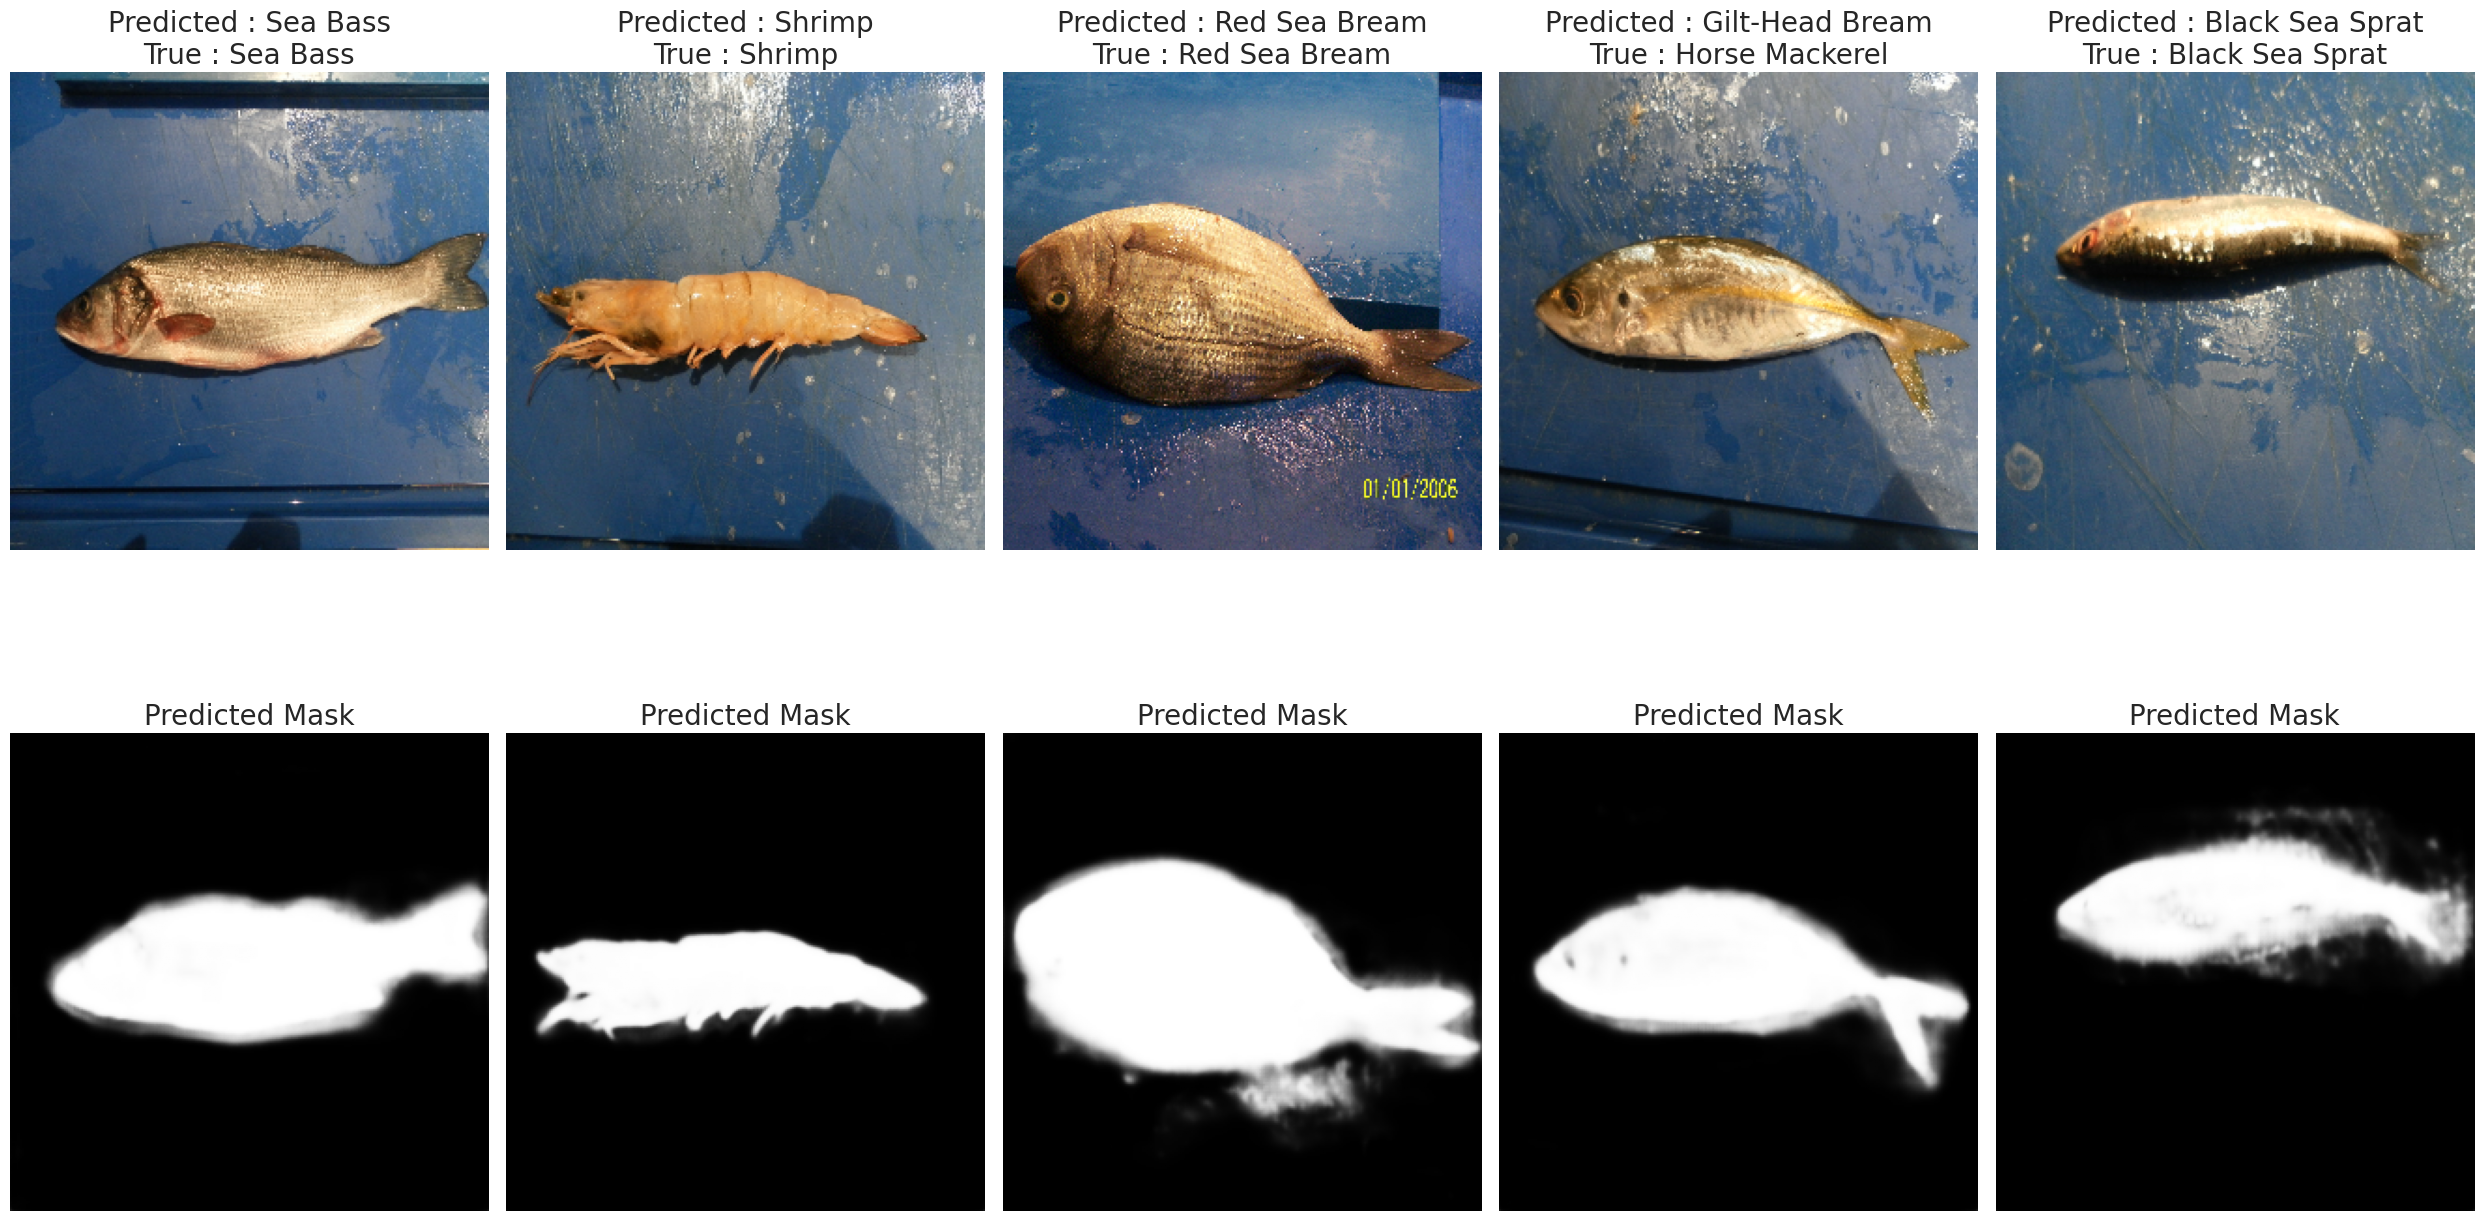

In [36]:
def predict(inputs , labels) : 
    idxs = np.random.choice(len(inputs) , size = 5 , replace = False)

    input_sample = inputs[idxs] 
    label_sample = labels[idxs] 
        
    sample_imgs = [] 
    
    for img_path , label in zip(input_sample , label_sample) : 
        img = read_image(img_path)
        sample_imgs.append(img) 

    x_test = np.array(sample_imgs)

    with tf.device("/GPU:0") :
        y_preds = model.predict(x_test)

    label_preds = np.argmax(y_preds['class'].round() , axis = 1)
    mask_preds = y_preds['mask'].squeeze()

    plt.figure(figsize=(25 , 15))
    
    for i in range(5): 
        plt.subplot(2, 5, i + 1)
        plt.imshow(x_test[i]) 
        plt.title(f"Predicted : {label_map[label_preds[i]]}\nTrue : {label_sample[i]}" , fontsize = 20)
        plt.axis("off")
        plt.subplot(2, 5, i + 6)
        plt.imshow(mask_preds[i], cmap='gray')
        plt.title("Predicted Mask" , fontsize = 20)
        plt.axis("off")
    
    plt.tight_layout()
    plt.show()
predict(test_imgs , test_labels)